# Superposed epoch analysis in the presence of high internal variability

We will be using a 4000yr  pre-industrial time series of monthly-mean NINO3.4 SST from the GFDL CM2.1, described in:


CM2.1 model formulation, and tropical/ENSO evaluation:
- Delworth et al. (2006): http://doi.org/10.1175/JCLI3629.1
- Wittenberg et al. (2006): http://doi.org/10.1175/JCLI3631.1

Pre-industrial control simulation, and long-range ENSO modulation & memory:
- Wittenberg et al. (2009): http://doi.org/10.1029/2009GL038710
- Wittenberg et al. (2014): http://doi.org/10.1175/JCLI-D-13-00577.1
- Atwood et al. (CD 2017): http://doi.org/10.1007/s00382-016-3477-9

h/t Andrew Wittenberg for providing the simulation.

## Exploratory analysis

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import LMRt
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import mquantiles
import xarray as xr
from matplotlib import gridspec
from scipy.signal import find_peaks
import pandas as pd
import pickle
from tqdm import tqdm
import pyleoclim as pyleo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
with xr.open_dataset('sst_nino34_cm2p1_1860.nc') as ds:
    print(ds)
    nino34 = ds['sst_nino34'].values
    time = ds['time'].values

#print(np.shape(nino34))

<xarray.Dataset>
Dimensions:     (bnds: 2, time: 48000)
Coordinates:
  * time        (time) object 0001-01-16 12:00:00 ... 4000-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object ...
    sst_nino34  (time) float32 ...
Attributes:
    history:      FERRET V7.443 (optimized) 15-Apr-19
    Conventions:  CF-1.6
    title:        CM2.1U_Control-1860_D4


Applying the tropical year average to this is a little tedious, so we skip some tests and load a up a file provided by Feng.

In [13]:
with open('cm2.1_nino34_TY.pkl', 'rb') as f:
    year, nino34_ann = pickle.load(f)
    
# ignore last value (NaN)
year = year[:-1]; nino34_ann = nino34_ann[:-1]

[Text(0, 0.5, 'PDF'),
 Text(0.5, 0, 'NINO3.4 SST'),
 Text(0.5, 1.0, 'Distribution of annual values')]

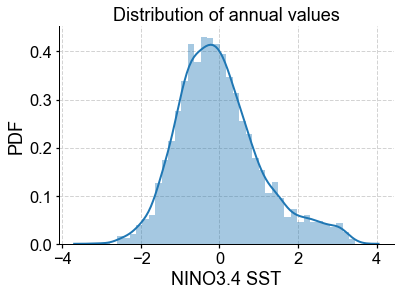

In [14]:
nino34_ann -= np.mean(nino34_ann) 
fig, ax = plt.subplots()
sns.distplot(nino34_ann,ax=ax)
sns.despine()
ax.set(title='Distribution of annual values',xlabel = 'NINO3.4 SST',ylabel = 'PDF')

This shows a nice skewness comparable to observations. Let's define a quantile-based threshold for El Niño and La Niña events:

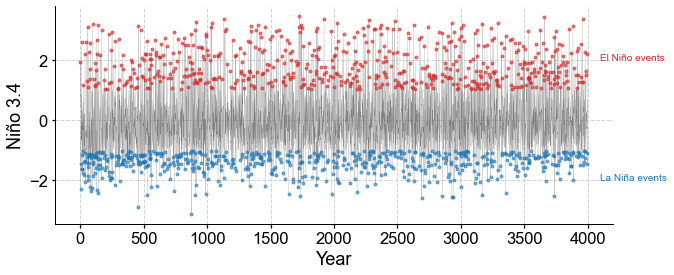

In [17]:
thre = 0.15
q = np.quantile(nino34_ann,[thre, 1-thre])
nina = np.where(nino34_ann <= q[0])
nino = np.where(nino34_ann >= q[1])

fig, ax = plt.subplots(figsize=[10, 4])
ax.plot(year, nino34_ann, color='gray',linewidth=0.2)
ax.plot(year[nino],nino34_ann[nino],'o',alpha=0.6,markersize=3,color='C3')
ax.plot(year[nina],nino34_ann[nina],'o',alpha=0.6,markersize=3,color='C0')
plt.text(4100,2,'El Niño events',color='C3')
plt.text(4100,-2,'La Niña events',color='C0')
# 
ax.set_xlabel('Year')
ax.set_ylabel('Niño 3.4')
ax.spines['right'].set_visible(False)                                                                                 
ax.spines['top'].set_visible(False)

In [55]:
len(nina[0])

600

## Accidental El Niño composites
Under stationary boundary conditions, warm (or cold) events can only appear in composites due to sampling artifacts, which should be larger for small number of key dates. Let us use resampling to evaluate the risk of wrongly identifying "forced" responses when none exists. Here our criterion for identifying warm events is that they exceed the threshold defined above.

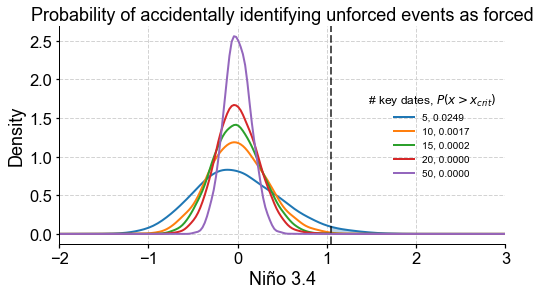

In [20]:
from scipy.stats import gaussian_kde 

nkeys = [5,10,15,20,50] 
clr = plt.cm.tab10(np.linspace(0,1,10))
prob = np.empty([len(nkeys),1])
nt  = len(year) 
nMC = 10000 # number of Monte Carlo draws
comp = np.empty([len(nkeys),nMC]) 
fig, ax = plt.subplots(figsize=(8,4))
xm = np.linspace(-2,3,200)
for key in nkeys:
    i = nkeys.index(key)
    for m in range(nMC):
        events = np.random.choice(nt, size=[key, 1], replace=False, p=None)
        comp[i,m] = np.mean(nino34_ann[events],axis=0)
    x = np.sort(comp[i,:]) # sort it by increasing values
    kde = gaussian_kde(x,bw_method=0.2)  # apply Kernel Density Estimation
      
    if any(x>=q[1]):
        comp_nino = x[x>=q[1]]
        prob[i] = kde.integrate_box_1d(q[1],5)          
        ax.fill_between(comp_nino,kde(comp_nino),alpha=0.3, color = clr[i])
    else:
        prob[i]=0
        
    ax.plot(xm,kde(xm),linewidth=2,color=clr[i],label=str(key) + ', '+ f'{prob[i][0]:3.4f}') 
    ax.axvline(q[1],linestyle='--',alpha=0.2,color='black')

plt.legend(title=r'# key dates, $P(x > x_{crit})$',loc=5,fontsize=10,title_fontsize=12)
ax.set_xlim([-2,3])
ax.set_xlabel('Niño 3.4')
ax.set_ylabel('Density')
ax.spines['right'].set_visible(False)                                                                                 
ax.spines['top'].set_visible(False)
ax.set_title('Probability of accidentally identifying unforced events as forced')

fig.savefig("CM2.1_compositing_accidents.pdf",dpi=200,pad_inches=0.2)

This shows that compositing is actually quite effective at filtering out unforced signals: the probability of misindentifying events as forced is less than 2.5% even for as low as 5 events, and vanishes to 0 for 20. 